# Exercise 9


## 1. Grover's algorithm for two qubits

(a) Implement an oracle and diffusion operator to search all strings of two bits to find `01`.

(b) Run the algorithm, and determine how many iterations are required to output `01` with high probability.

1) check qiskit textbook

2) Find oracle and diffusion operator, to make "grover-part" and repeat is as often as possible.
Hint: Add step at the beginning, that only has effects when repeating.

3) High probability typically means >90%. So find how many grover steps you need to perform to reach this rate.

Optional: Add noise using other chapter linked in Grover's lecture.

Our oracle looks like this: $$U_\omega = (I - |01\rangle\langle01|) - |01\rangle\langle01| = \begin{pmatrix}
1&&0&&0&&0\\
0&&-1&&0&&0\\
0&&0&&1&&0\\
0&&0&&0&&1\\
\end{pmatrix} = CZ^{1,0}$$ 

In [13]:
from qiskit import *
sim = Aer.get_backend('aer_simulator')
from qiskit.visualization import array_to_latex, circuit_drawer, plot_histogram
from qiskit.extensions import *
from qiskit.providers.ibmq import least_busy

In [14]:
N = 2
qc = QuantumCircuit(2)

In [15]:
def diffuser(n_qubits):
    diffuser = QuantumCircuit(n_qubits)
    diffuser.h(list(range(n_qubits)))
    diffuser.x(list(range(n_qubits)))
    diffuser.h(n_qubits-1)
    diffuser.mct(list(range(n_qubits-1)), n_qubits-1)
    diffuser.h(n_qubits-1)
    diffuser.x(list(range(n_qubits)))
    diffuser.h(list(range(n_qubits)))
    diffuser = diffuser.to_gate()
    diffuser.name = "Diffuser"
    return diffuser

In [16]:
u_f = UnitaryGate([[1,0,0,0],
                   [0,-1,0,0], 
                   [0,0,1,0],
                   [0,0,0,1]])

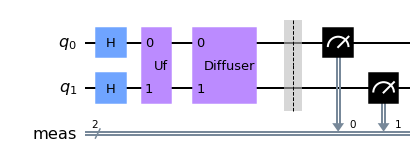

In [17]:
qc.h(list(range(N)))
qc.unitary(u_f, list(range(N)), 'Uf')
qc.append(diffuser(N), list(range(N)))
qc.measure_all()
qc.draw(output='mpl')

In [18]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, sim)

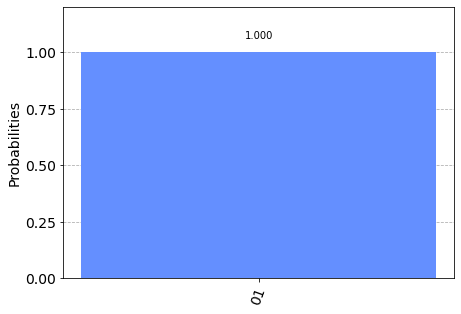

In [19]:
result = sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)

## 2. Grover's algorithm for three qubits

(a) Implement an oracle and diffusion operator to search all strings of three bits to find `100`.

(b) Run the algorithm, and determine how many iterations are required to output `100` with high probability.

Hint: Use ccz or ccx this time. 

In [28]:
N = 3
qc = QuantumCircuit(N)

In [29]:
u_f = UnitaryGate([[1, 0, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0, 0, 0, 0],
                   [0, 0, 0, 0,-1, 0, 0, 0],
                   [0, 0, 0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 1, 0],
                   [0, 0, 0, 0, 0, 0, 0, 1]]) # Unitary to apply phase of -1 to |100>

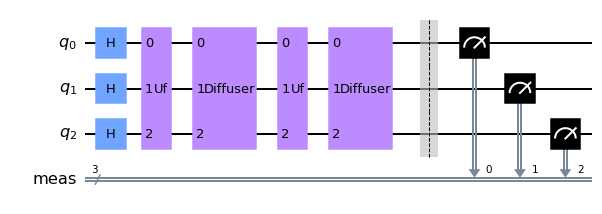

In [30]:
qc.h(list(range(N))) # Put qubits into superpositions of all numbers
for i in range(2):
    qc.unitary(u_f, list(range(N)), 'Uf')
    qc.append(diffuser(N), list(range(N)))
qc.measure_all()
qc.draw(output='mpl')

In [31]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, sim)

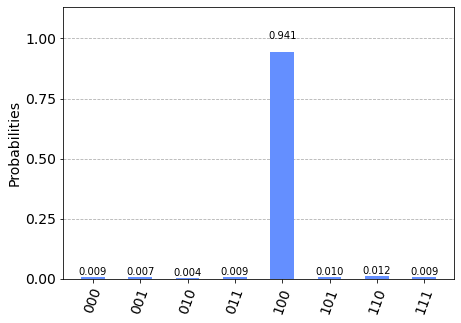

In [32]:
result = sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [33]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2022-05-06 15:50:53,510: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_quito


In [34]:
from qiskit.tools.monitor import job_monitor
transpiled_qc = transpile(qc, device, optimization_level=3)
job = device.run(transpiled_qc)
job_monitor(job, interval=2)

Job Status: job has successfully run


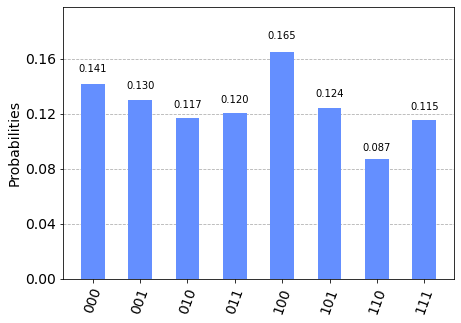

In [35]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(qc)
plot_histogram(answer)